Please go through the [article](https://www.analyticsvidhya.com/blog/2019/09/guide-automatic-highlight-generation-python-without-machine-learning/) to understand the approach for automatically generating highlights without using machine learning and deep learning

# Understanding the Problem Statement

Cricket is the most famous sport in India and played in almost all parts of the country. So, being a die-hard cricket fan, I decided to automate the process of highlights extraction from a full match cricket video. Nevertheless, the same idea can be applied to other sports as well.

For this article, I have considered only the first 6 overs (PowerPlay) of the semi-final match between India and Australia at the T20 World Cup in 2007. You can watch the full match on YouTube [here](https://www.youtube.com/watch?v=lFq4eW9ewRE&t=2162s) and download the video for the first six overs from [here](https://drive.google.com/open?id=1FRODSq1dgp-JvUcXRALKjn6bvIu15gU6).

# Automatic Highlight Generation in Python

I have extracted the audio from the video with the help of a software called WavePad Audio Editor. You can download the audio clip from [here](https://drive.google.com/open?id=1FRODSq1dgp-JvUcXRALKjn6bvIu15gU6)

In [18]:
path='F:/work @av/Cricket highlights generation/cricket/'
filename='powerplay.wav'
import librosa
x, sr = librosa.load(path+filename,sr=16000)

We can get the duration of the audio clip in minutes using the code below:

In [19]:
int(librosa.get_duration(x, sr)/60)

23

Now, we will break the audio into chunks of 5 seconds each since we are interested in finding out whether a particular audio chunk contains a rise in the audio voice: 

In [20]:
max_slice=5
window_length = max_slice * sr

Let us listen to one of the audio chunks:

In [21]:
import IPython.display as ipd
a=x[21*window_length:22*window_length]
ipd.Audio(a, rate=sr)

Compute the energy for the chunk:

In [22]:
energy = sum(abs(a**2))
print(energy)

16124.641480222366


In [23]:
len(a)

80000

Visualize the chunk in the time-series domain:

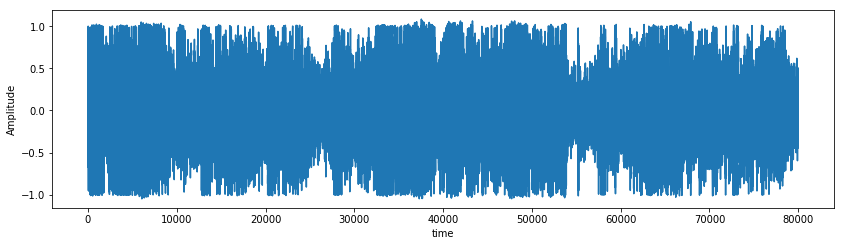

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(a)

As we can see, the amplitude of a signal is varying with respect to time. Next, compute the Short Time Energy for every chunk:

In [25]:
import numpy as np
energy = np.array([sum(abs(x[i:i+window_length]**2)) for i in range(0, len(x), window_length)])

In [26]:
energy

array([ 5097.26347369,  7970.31339209,  3726.99525639,  1108.26318258,
        6329.92744913,  3380.43352551,  2725.43021046,  7596.90564388,
        2651.70910939,   670.22544945,  6422.10616929,  7240.42809321,
         599.64768003,  7637.47393052,  1390.11196694,  4435.19547629,
        6870.55959662,  5832.84127552, 16378.27583011, 18189.98069064,
       21468.88590517, 16124.64148022, 15446.15875398, 15814.72701125,
        9059.61883113,  3591.69180577,  1157.28960112,  6500.04005529,
        3526.83443963,  3695.08668856,  3966.03618015,  3316.85012946,
        3851.36922996,  3150.71452403,  7944.49626939,  3872.42189556,
        1385.94509716,  2569.586072  ,   883.96296774,  4056.1573833 ,
        4653.30955505,  4801.31149315,  3232.40846686,   902.21320373,
        2512.77062231,  3555.70271583,  4452.66267368,  3996.07856175,
       12888.19520279,  2948.10413565,  2632.27309699,  3379.8364582 ,
        4917.01688766,  6687.66480122,  5553.6469798 , 10343.12081885,
      

Let us understand the Short Time Energy distribution of the chunks:

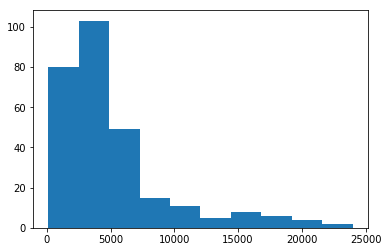

In [27]:
import matplotlib.pyplot as plt
plt.hist(energy)
plt.show()

The energy distribution is right-skewed as we can see in the above plot. We will choose the extreme value as the threshold since we are interested in the clips only when the commentator’s speech and spectators cheers are high.

Here, I am considering the threshold to be 12,000 as it lies on the tail of the distribution. Feel free to experiment with different values and see what result you get.

In [28]:
import pandas as pd
df=pd.DataFrame(columns=['energy','start','end'])

In [29]:
thresh=12000
row_index=0
for i in range(len(energy)):
    value=energy[i]
    if(value>=thresh):
        i=np.where(energy == value)[0]
        df.loc[row_index,'energy']=value
        df.loc[row_index,'start']=i[0] * 5
        df.loc[row_index,'end']=(i[0]+1) * 5
        row_index= row_index + 1

In [30]:
df

,energy,start,end
0,16378.3,90,95
1,18190,95,100
2,21468.9,100,105
3,16124.6,105,110
4,15446.2,110,115
5,15814.7,115,120
6,12888.2,240,245
7,15368.1,875,880
8,14910.6,880,885
9,13092.3,885,890


Merge consecutive time intervals of audio clips into one:

In [31]:
temp=[]
i=0
j=0
n=len(df) - 2
m=len(df) - 1
while(i<=n):
    j=i+1
    while(j<=m):
        if(df['end'][i] == df['start'][j]):
            df.loc[i,'end'] = df.loc[j,'end']
            temp.append(j)
            j=j+1
        else:
            i=j
            break      

In [32]:
df.drop(temp,axis=0,inplace=True)

In [33]:
df

,energy,start,end
0,16378.3,90,120
6,12888.2,240,245
7,15368.1,875,890
10,12649.3,940,950
12,12518.7,955,960
13,20301.6,1170,1180
15,18940.9,1220,1230
17,16135.4,1235,1245
19,20348.5,1255,1270
22,13311.5,1325,1330


Extract the video within a particular time interval to form highlights. Remember – Since the commentator’s speech and spectators’ cheers increase only after the batsman has played a shot, I am considering only five seconds post every excitement clip:

In [34]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
start=np.array(df['start'])
end=np.array(df['end'])
for i in range(len(df)):
    if(i!=0):
        start_lim = start[i] - 5
    else:
        start_lim = start[i] 
    end_lim   = end[i]   
    filename="F:\work @av\Cricket highlights generation\cricket\highlights\cut" + str(i+1) + ".mp4"
    ffmpeg_extract_subclip(path+"powerplay.mp4",start_lim,end_lim,targetname=filename)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


I have used online editors to merge all the extracted clips to form a single video. Here are the highlights generated from the PowerPlay using a simple speech analysis approach:

[Watch highlights](https://www.youtube.com/watch?v=sva7T4yNWEM&t=1s)

The key takeaways from the project – have a thorough understanding of the domain as well as the data before getting into the model building process since it drives us to a better solution in most of the problems.